## From mord
These first few cells are taken directly from the ordinal regression package, with some modifications for the logistic regression with weights for quantile elicitation

In [ ]:
import numpy as np
from scipy import optimize
import scipy
from sklearn import base, metrics
from sklearn.utils.validation import check_X_y

In [ ]:
class LogisticAT(base.BaseEstimator):
    """
    Classifier that implements the ordinal logistic model (All-Threshold variant)

    Parameters
    ----------
    alpha: float
        Regularization parameter. Zero is no regularization, higher values
        increate the squared l2 regularization.

    References
    ----------
    J. D. M. Rennie and N. Srebro, "Loss Functions for Preference Levels :
    Regression with Discrete Ordered Labels," in Proceedings of the IJCAI
    Multidisciplinary Workshop on Advances in Preference Handling, 2005.
    """
    def __init__(self, alpha=1., verbose=0, max_iter=1000):
        self.alpha = alpha
        self.verbose = verbose
        self.max_iter = max_iter

    def fit(self, X, y, sample_weight=None):
        _y = np.array(y).astype(np.int)
        if np.abs(_y - y).sum() > 0.1:
            raise ValueError('y must only contain integer values')
        self.classes_ = np.unique(y)
        self.n_class_ = self.classes_.max() - self.classes_.min() + 1
        y_tmp = y - y.min()  # we need classes that start at zero
        self.coef_, self.theta_ = threshold_fit(
            X, y_tmp, self.alpha, self.n_class_, mode='AE',
            verbose=self.verbose, max_iter=self.max_iter,
            sample_weight=sample_weight)
        return self

    def predict(self, X):
        return threshold_predict(X, self.coef_, self.theta_) +\
         self.classes_.min()

    def predict_proba(self, X):
        return threshold_proba(X, self.coef_, self.theta_)

    def score(self, X, y, sample_weight=None):
        pred = self.predict(X)
        return -metrics.mean_absolute_error(
            pred,
            y,
            sample_weight=sample_weight)


class LogisticIT(base.BaseEstimator):
    """
    Classifier that implements the ordinal logistic model
    (Immediate-Threshold variant).

    Contrary to the OrdinalLogistic model, this variant
    minimizes a convex surrogate of the 0-1 loss, hence
    the score associated with this object is the accuracy
    score, i.e. the same score used in multiclass
    classification methods (sklearn.metrics.accuracy_score).

    Parameters
    ----------
    alpha: float
        Regularization parameter. Zero is no regularization, higher values
        increate the squared l2 regularization.

    References
    ----------
    J. D. M. Rennie and N. Srebro, "Loss Functions for Preference Levels :
    Regression with Discrete Ordered Labels," in Proceedings of the IJCAI
    Multidisciplinary Workshop on Advances in Preference Handling, 2005.
    """
    def __init__(self, alpha=1., verbose=0, max_iter=1000):
        self.alpha = alpha
        self.verbose = verbose
        self.max_iter = max_iter

    def fit(self, X, y, sample_weight=None):
        _y = np.array(y).astype(np.int)
        if np.abs(_y - y).sum() > 0.1:
            raise ValueError('y must only contain integer values')
        self.classes_ = np.unique(y)
        self.n_class_ = self.classes_.max() - self.classes_.min() + 1
        y_tmp = y - y.min()  # we need classes that start at zero
        self.coef_, self.theta_ = threshold_fit(
            X, y_tmp, self.alpha, self.n_class_,
            mode='0-1', verbose=self.verbose, max_iter=self.max_iter,
            sample_weight=sample_weight)
        return self

    def predict(self, X):
        return threshold_predict(X, self.coef_, self.theta_) +\
         self.classes_.min()

    def predict_proba(self, X):
        return threshold_proba(X, self.coef_, self.theta_)

    def score(self, X, y, sample_weight=None):
        pred = self.predict(X)
        return metrics.accuracy_score(
            pred,
            y,
            sample_weight=sample_weight)


class LogisticSE(base.BaseEstimator):
    """
    Classifier that implements the ordinal logistic model
    (Squared Error variant).

    Contrary to the OrdinalLogistic model, this variant
    minimizes a convex surrogate of the 0-1 (?) loss ...

    TODO: double check this description (XXX)

    Parameters
    ----------
    alpha: float
        Regularization parameter. Zero is no regularization, higher values
        increase the squared l2 regularization.

    References
    ----------
    J. D. M. Rennie and N. Srebro, "Loss Functions for Preference Levels :
    Regression with Discrete Ordered Labels," in Proceedings of the IJCAI
    Multidisciplinary Workshop on Advances in Preference Handling, 2005.
    """
    def __init__(self, alpha=1., verbose=0, max_iter=100000):
        self.alpha = alpha
        self.verbose = verbose
        self.max_iter = max_iter

    def fit(self, X, y, sample_weight=None):
        _y = np.array(y).astype(np.int)
        if np.abs(_y - y).sum() > 1e-3:
            raise ValueError('y must only contain integer values')
        self.classes_ = np.unique(y)
        self.n_class_ = self.classes_.max() - self.classes_.min() + 1
        y_tmp = y - y.min()  # we need classes that start at zero
        self.coef_, self.theta_ = threshold_fit(
            X, y_tmp, self.alpha, self.n_class_,
            mode='SE', verbose=self.verbose, max_iter=self.max_iter,
            sample_weight=sample_weight)
        return self

    def predict(self, X):
        return threshold_predict(X, self.coef_, self.theta_) +\
         self.classes_.min()

    def predict_proba(self, X):
        return threshold_proba(X, self.coef_, self.theta_)

    def score(self, X, y, sample_weight=None):
        pred = self.predict(X)
        return -metrics.mean_squared_error(
            pred,
            y,
            sample_weight=sample_weight)


In [ ]:
"""
This implements the margin-based ordinal regression methods described
in http://arxiv.org/abs/1408.2327
"""

def sigmoid(t):
    # sigmoid function, 1 / (1 + exp(-t))
    # stable computation
    idx = t > 0
    out = np.zeros_like(t)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out


def log_loss(Z):
    # stable computation of the logistic loss
    idx = Z > 0
    out = np.zeros_like(Z)
    out[idx] = np.log(1 + np.exp(-Z[idx]))
    out[~idx] = (-Z[~idx] + np.log(1 + np.exp(Z[~idx])))
    return out

def direct_loss(Z):
    # Weighted surrogate loss
    idx = Z > 0
    out = np.zeros_like(Z)
    out[idx] = 0
    out[~idx] = -Z[~idx]
    return out

def obj_margin(x0, X, y, alpha, n_class, weights, L, sample_weight):
    """
    Objective function for the general margin-based formulation
    """

    w = x0[:X.shape[1]]
    c = x0[X.shape[1]:]
    theta = L.dot(c)
    loss_fd = weights[y]

    Xw = X.dot(w)
    Alpha = theta[:, None] - Xw  # (n_class - 1, n_samples)
    S = np.sign(np.arange(n_class - 1)[:, None] - y + 0.5)

    err = loss_fd.T * log_loss(S * Alpha)
    if sample_weight is not None:
        err *= sample_weight
    obj = np.sum(err)
    obj += alpha * 0.5 * (np.dot(w, w))
    return obj

def obj_margin_direct(x0, X, y, alpha, n_class, weights, L, sample_weight):
    """
    Objective function for the general margin-based formulation
    """

    w = x0[:X.shape[1]]
    c = x0[X.shape[1]:]
    theta = L.dot(c)
    loss_fd = weights[y]

    Xw = X.dot(w)
    Alpha = theta[:, None] - Xw  # (n_class - 1, n_samples)
    S = np.sign(np.arange(n_class - 1)[:, None] - y + 0.5)

    err = loss_fd.T * direct_loss(S * Alpha)
    if sample_weight is not None:
        err *= sample_weight
    obj = np.sum(err)
    #obj += alpha * 0.5 * (np.dot(w, w))
    return obj

def grad_margin(x0, X, y, alpha, n_class, weights, L, sample_weight):
    """
    Gradient for the general margin-based formulation
    """

    w = x0[:X.shape[1]]
    c = x0[X.shape[1]:]
    theta = L.dot(c)
    loss_fd = weights[y]

    Xw = X.dot(w)
    Alpha = theta[:, None] - Xw  # (n_class - 1, n_samples)
    S = np.sign(np.arange(n_class - 1)[:, None] - y + 0.5)
    # Alpha[idx] *= -1
    # W[idx.T] *= -1

    Sigma = S * loss_fd.T * sigmoid(-S * Alpha)
    if sample_weight is not None:
        Sigma *= sample_weight

    grad_w = X.T.dot(Sigma.sum(0)) + alpha * w

    grad_theta = -Sigma.sum(1)
    grad_c = L.T.dot(grad_theta)
    return np.concatenate((grad_w, grad_c), axis=0)


def threshold_fit(X, y, alpha, n_class, mode='AE',
                  max_iter=1000, verbose=False, tol=1e-12,
                  sample_weight=None):
    """
    Solve the general threshold-based ordinal regression model
    using the logistic loss as surrogate of the 0-1 loss

    Parameters
    ----------
    mode : string, one of {'AE', '0-1', 'SE'}

    """

    X, y = check_X_y(X, y, accept_sparse='csr')
    unique_y = np.sort(np.unique(y))
    if not np.all(unique_y == np.arange(unique_y.size)):
        raise ValueError(
            'Values in y must be %s, instead got %s'
            % (np.arange(unique_y.size), unique_y))

    n_samples, n_features = X.shape

    # convert from c to theta
    L = np.zeros((n_class - 1, n_class - 1))
    L[np.tril_indices(n_class-1)] = 1.

    if mode == 'AE':
        # loss forward difference
        loss_fd = np.ones((n_class, n_class - 1))
    elif mode == '0-1':
        loss_fd = np.diag(np.ones(n_class - 1)) + \
            np.diag(np.ones(n_class - 2), k=-1)
        loss_fd = np.vstack((loss_fd, np.zeros(n_class - 1)))
        loss_fd[-1, -1] = 1  # border case
    elif mode == 'SE':
        a = np.arange(n_class-1)
        b = np.arange(n_class)
        loss_fd = np.abs((a - b[:, None])**2 - (a - b[:, None]+1)**2)
    else:
        raise NotImplementedError

    x0 = np.zeros(n_features + n_class - 1)
    x0[X.shape[1]:] = np.arange(n_class - 1)
    options = {'maxiter' : max_iter, 'disp': verbose}
    if n_class > 2:
        bounds = [(None, None)] * (n_features + 1) + \
                 [(0, None)] * (n_class - 2)
    else:
        bounds = None

    sol = optimize.minimize(obj_margin, x0, method='L-BFGS-B',
        jac=grad_margin, bounds=bounds, options=options,
        args=(X, y, alpha, n_class, loss_fd, L, sample_weight),
        tol=tol)
    if verbose and not sol.success:
        print(sol.message)

    w, c = sol.x[:X.shape[1]], sol.x[X.shape[1]:]
    theta = L.dot(c)
    return w, theta

def threshold_fit_quantile(X, y, alpha, gamma, n_class, mode='QE',
                  max_iter=1000, verbose=False, tol=1e-12,
                  sample_weight=None):
    """
    Solve the general threshold-based ordinal regression model
    using the logistic loss as surrogate of the 0-1 loss

    Parameters
    ----------
    mode : string, one of {'AE', '0-1', 'Direct'}

    """

    X, y = check_X_y(X, y, accept_sparse='csr')
    unique_y = np.sort(np.unique(y))
    if not np.all(unique_y == np.arange(unique_y.size)):
        raise ValueError(
            'Values in y must be %s, instead got %s'
            % (np.arange(unique_y.size), unique_y))

    n_samples, n_features = X.shape

    # convert from c to theta
    L = np.zeros((n_class - 1, n_class - 1))
    L[np.tril_indices(n_class-1)] = 1.

    if mode == '0-1' or mode == 'Direct':
        loss_fd = (1 - gamma) * np.diag(np.ones(n_class - 1)) + \
                  gamma * np.diag(np.ones(n_class - 2), k=-1)
        loss_fd = np.vstack((loss_fd, np.zeros(n_class - 1)))
        loss_fd[-1, -1] = gamma  # border case
    elif mode == 'AE':
        # loss forward difference
        loss_fd = np.ones((n_class, n_class - 1)) * (1 - gamma)
        lower_indices = np.tril_indices(n = n_class, m = (n_class - 1), k = -1)
        loss_fd[lower_indices] = gamma
    else:
        raise NotImplementedError

    x0 = np.zeros(n_features + n_class - 1)
    x0[X.shape[1]:] = np.arange(n_class - 1)
    options = {'maxiter' : max_iter, 'disp': verbose}
    if n_class > 2:
        bounds = [(None, None)] * (n_features + 1) + \
                 [(0, None)] * (n_class - 2)
    else:
        bounds = None

    if (mode != 'Direct'): 
        sol = optimize.minimize(obj_margin, x0, method='L-BFGS-B',
            jac=grad_margin, bounds=bounds, options=options,
            args=(X, y, alpha, n_class, loss_fd, L, sample_weight),
            tol=tol)
    else:
        sol = optimize.minimize(obj_margin_direct, x0, method='L-BFGS-B',
            bounds=bounds, options=options,
            args=(X, y, alpha, n_class, loss_fd, L, sample_weight),
            tol=tol)
    
    if verbose and not sol.success:
        print(sol.message)

    w, c = sol.x[:X.shape[1]], sol.x[X.shape[1]:]
    theta = L.dot(c)
    return w, theta


def threshold_predict(X, w, theta):
    """
    Class numbers are assumed to be between 0 and k-1
    """
    tmp = theta[:, None] - np.asarray(X.dot(w))
    pred = np.sum(tmp < 0, axis=0).astype(np.int)
    return pred


def threshold_proba(X, w, theta):
    """
    Class numbers are assumed to be between 0 and k-1. Assumes
    the `sigmoid` link function is used.
    """
    eta = theta[:, None] - np.asarray(X.dot(w), dtype=np.float64)
    prob = np.pad(
        sigmoid(eta).T,
        pad_width=((0, 0), (1, 1)),
        mode='constant',
        constant_values=(0, 1))
    return np.diff(prob)


In [ ]:
class LogisticQuantileIT(base.BaseEstimator):
    """
    Classifier that implements the ordinal logistic model for quantile estimation

    """
    def __init__(self, gamma=0.5, alpha=1., verbose=0, max_iter=1000):
        self.gamma = gamma
        self.alpha = alpha
        self.verbose = verbose
        self.max_iter = max_iter

    def fit(self, X, y, sample_weight=None):
        _y = np.array(y).astype(np.int)
        if np.abs(_y - y).sum() > 0.1:
            raise ValueError('y must only contain integer values')
        self.classes_ = np.unique(y)
        self.n_class_ = self.classes_.max() - self.classes_.min() + 1
        y_tmp = y - y.min()  # we need classes that start at zero
        self.coef_, self.theta_ = threshold_fit_quantile(
            X, y_tmp, self.alpha, self.gamma, self.n_class_,
            mode='0-1', verbose=self.verbose, max_iter=self.max_iter,
            sample_weight=sample_weight)
        return self

    def predict(self, X):
        return threshold_predict(X, self.coef_, self.theta_) +\
         self.classes_.min()

    def predict_proba(self, X):
        return threshold_proba(X, self.coef_, self.theta_)

    def score(self, X, y, sample_weight=None):
        pred = self.predict(X)
        return metrics.accuracy_score(
            pred,
            y,
            sample_weight=sample_weight)
    
class LogisticQuantileAT(base.BaseEstimator):
    """
    Classifier that implements the ordinal logistic model for quantile estimation

    """
    def __init__(self, gamma=0.5, alpha=1., verbose=0, max_iter=1000):
        self.gamma = gamma
        self.alpha = alpha
        self.verbose = verbose
        self.max_iter = max_iter

    def fit(self, X, y, sample_weight=None):
        _y = np.array(y).astype(np.int)
        if np.abs(_y - y).sum() > 0.1:
            raise ValueError('y must only contain integer values')
        self.classes_ = np.unique(y)
        self.n_class_ = self.classes_.max() - self.classes_.min() + 1
        y_tmp = y - y.min()  # we need classes that start at zero
        self.coef_, self.theta_ = threshold_fit_quantile(
            X, y_tmp, self.alpha, self.gamma, self.n_class_,
            mode='AE', verbose=self.verbose, max_iter=self.max_iter,
            sample_weight=sample_weight)
        return self

    def predict(self, X):
        return threshold_predict(X, self.coef_, self.theta_) +\
         self.classes_.min()

    def predict_proba(self, X):
        return threshold_proba(X, self.coef_, self.theta_)

    def score(self, X, y, sample_weight=None):
        pred = self.predict(X)
        return metrics.accuracy_score(
            pred,
            y,
            sample_weight=sample_weight)
    
class LogisticQuantileDirect(base.BaseEstimator):
    """
    Classifier that implements the ordinal logistic model for quantile estimation

    """
    def __init__(self, gamma=0.5, alpha=1., verbose=0, max_iter=1000):
        self.gamma = gamma
        self.alpha = alpha
        self.verbose = verbose
        self.max_iter = max_iter

    def fit(self, X, y, sample_weight=None):
        _y = np.array(y).astype(np.int)
        if np.abs(_y - y).sum() > 0.1:
            raise ValueError('y must only contain integer values')
        self.classes_ = np.unique(y)
        self.n_class_ = self.classes_.max() - self.classes_.min() + 1
        y_tmp = y - y.min()  # we need classes that start at zero
        self.coef_, self.theta_ = threshold_fit_quantile(
            X, y_tmp, self.alpha, self.gamma, self.n_class_,
            mode='Direct', verbose=self.verbose, max_iter=self.max_iter,
            sample_weight=sample_weight)
        return self

    def predict(self, X):
        return threshold_predict(X, self.coef_, self.theta_) +\
         self.classes_.min()

    def predict_proba(self, X):
        return threshold_proba(X, self.coef_, self.theta_)

    def score(self, X, y, sample_weight=None):
        pred = self.predict(X)
        return metrics.accuracy_score(
            pred,
            y,
            sample_weight=sample_weight)

## Tests

## Quantile Elicitation

In [178]:
def compute_quantile(X_test, alpha):
    ## Known from data generation
    d = 2
    w = np.array([1/d]*d) 
    portions = np.array([3, 7, 10, 15, 19, 21]) * 8
    k = 6
    
    projection_points = X_test.dot(w) * d
    return get_class_quantiles(projection_points, portions, k, alpha)
    
def get_class_quantiles(projection_points, portions, k, alpha):
    y = np.matrix(np.zeros(projection_points.size)).T
    for i in range(0, projection_points.size):
        curr_point = projection_points[i]
        likely_class = np.argmax((curr_point - portions) < 0)
        if(likely_class == k - 1):
            y[i] = k-1
        else:
            if(likely_class > 0):
                prob_up = 1 - (portions[likely_class] - curr_point) / (portions[likely_class] - portions[likely_class - 1])
            else:
                prob_up = 1 - (portions[likely_class] - curr_point) / (portions[likely_class] - 0)
            y[i] = likely_class + 1 * (prob_up > 1 - alpha)
    return y

In [183]:
from sklearn import linear_model, metrics
import pandas as pd
import numpy as np

## Quantile to be elicited
a = 0.7

X_train = pd.read_csv('quantile_synthetic_features.csv', names=['dim1', 'dim2'])
y = pd.read_csv('quantile_synthetic_labels.csv', names=['y'])
y_train = np.array(y.iloc[:, 0]).astype(int)

X_test = pd.read_csv('quantile_synthetic_testfeatures.csv', names=['dim1', 'dim2'])
y_test = compute_quantile(X_test, a)

clf1 = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial')
clf1.fit(X_train, y_train)

print('Mean Absolute Error of LogisticRegression: %s' %
      metrics.mean_absolute_error(clf1.predict(X_test), y_test))

clf2 = LogisticAT(alpha=1.)
clf2.fit(X_train, y_train)
print('Mean Absolute Error of LogisticAT %s' %
      metrics.mean_absolute_error(clf2.predict(X_test), y_test))

clf3 = LogisticIT(alpha=1.)
clf3.fit(X_train, y_train)
print('Mean Absolute Error of LogisticIT %s' %
      metrics.mean_absolute_error(clf3.predict(X_test), y_test))

clf4 = LogisticSE(alpha=1.)
clf4.fit(X_train, y_train)
print('Mean Absolute Error of LogisticSE %s' %
      metrics.mean_absolute_error(clf4.predict(X_test), y_test))

clf5 = LogisticQuantileIT(gamma=a, alpha=1.)
clf5.fit(X_train, y_train)
print('Mean Absolute Error of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
      metrics.mean_absolute_error(clf5.predict(X_test), y_test))

clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
clf6.fit(X_train, y_train)
print('Mean Absolute Error of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
      metrics.mean_absolute_error(clf6.predict(X_test), y_test))

clf7 = LogisticQuantileDirect(gamma=a, alpha=1.)
clf7.fit(X_train, y_train)
print('Mean Absolute Error of LogisticQuantileDirect, gamma=' + str(a) + ' %s' %
      metrics.mean_absolute_error(clf7.predict(X_test), y_test))

Mean Absolute Error of LogisticRegression: 0.1521
Mean Absolute Error of LogisticAT 0.1724
Mean Absolute Error of LogisticIT 0.1725
Mean Absolute Error of LogisticSE 0.1727
Mean Absolute Error of LogisticQuantileIT, gamma=0.7 0.0412
Mean Absolute Error of LogisticQuantileAT, gamma=0.7 0.0446
Mean Absolute Error of LogisticQuantileDirect, gamma=0.7 0.187


## Plot Threshold Boundaries

In [213]:
from matplotlib import pyplot as plt
def plot_clf(coef, theta):
    ## From data generation
    last_point = 170
    
    x = np.arange(0, 170, 0.5)
    y = x * (coef[0] / coef[1])
    plt.plot(x,y)
    
    for t in theta:
        t_y = x * (-coef[1] / coef[0]) + t * (2 / coef[0])
        t_y = t_y * (t_y > 0)
        plt.plot(x, t_y)

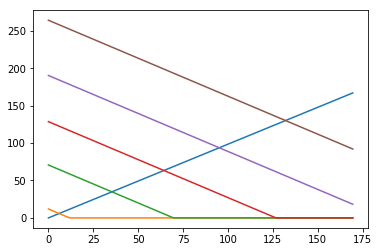

In [214]:
plot_clf(clf5.coef_, clf5.theta_)

## Multiclass Classification

In [ ]:
k = 100
n = 10000
X_train = pd.read_csv('multiclass_train_features_k' + str(k) + 'n' + str(n) + '.csv')
y = pd.read_csv('multiclass_train_labels_k' + str(k) + 'n' + str(n) + '.csv')
y_train = np.array(y.iloc[:, 0]).astype(int)

X_test = pd.read_csv('multiclass_test_features_k' + str(k) + 'n' + str(n) + '.csv')
y = pd.read_csv('multiclass_test_labels_k' + str(k) + 'n' + str(n) + '.csv')
y_test = np.array(y.iloc[:, 0]).astype(int)

In [ ]:
ITs = []
IT_predictions = []
ATs = []
AT_predictions = []

s = 10
for i in range(1, s):
    a = i / s
    clf5 = LogisticQuantileIT(gamma=a, alpha=1.)
    clf5.fit(X_train, y_train)
    ITpredictions = clf5.predict(X_test)
    print('Mean Absolute Error of LogisticQuantileIT, gamma=' + str(a) + ' %s' %
          metrics.mean_absolute_error(ITpredictions, y_test))
    ITs.append(clf5)
    IT_predictions.append(ITpredictions)

    clf6 = LogisticQuantileAT(gamma=a, alpha=1.)
    clf6.fit(X_train, y_train)
    ATpredictions = clf6.predict(X_test)
    print('Mean Absolute Error of LogisticQuantileAT, gamma=' + str(a) + ' %s' %
          metrics.mean_absolute_error(ATpredictions, y_test))
    ATs.append(clf6)
    AT_predictions.append(ATpredictions)

#     clf7 = LogisticQuantileDirect(gamma=a, alpha=1.)
#     clf7.fit(X_train, y_train)
#     print('Mean Absolute Error of LogisticQuantileDirect, gamma=' + str(a) + ' %s' %
#           metrics.mean_absolute_error(clf7.predict(X_test), y_test))

In [ ]:
## Logistic Regression for comparison
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train.flatten())

In [ ]:
sum(clf.predict(X_test) != y_test.flatten()) / len(X_test)

In [ ]:
clf.predict(X_test)

In [ ]:
metrics.mean_absolute_error(clf.predict(X_test), y_test.flatten())

In [ ]:
np.set_printoptions(threshold=np.nan)
full = np.zeros((4999, 2))
full[:, 0] = clf.predict(X_test)
full[:,1] = y_test
print(full)

In [ ]:
## OVA SVM
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train.flatten()) 

print(sum(lin_clf.predict(X_test) != y_test.flatten()) / len(X_test))

In [ ]:
np.set_printoptions(threshold=np.nan)
full = np.zeros((4999, 2))
full[:, 0] = AT_predictions[1]
full[:,1] = y_test
print(full)

In [ ]:
sum(AT_predictions[4] != y_test.flatten()) / len(X_test)

In [ ]:
AT_preds = np.zeros((4999, 10))

In [ ]:
for i in range(1, 10):
    AT_preds[:, i] = AT_predictions[i - 1]

In [ ]:
np.sum(scipy.stats.mode(AT_preds.T).mode!= y_test.flatten()) / len(X_test)

In [ ]:
metrics.mean_absolute_error(scipy.stats.mode(AT_preds.T).mode, y_test.flatten())

In [ ]:
IT_preds = np.zeros((4999, 10))
for i in range(1, 10):
    IT_preds[:, i-1] = IT_predictions[i - 1]

In [ ]:
np.sum(scipy.stats.mode(IT_preds.T).mode!= y_test.flatten()) / len(X_test)

## Simplex Testing